In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import numpy as np
from fbprophet import Prophet

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Interactive Plot
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py
py.init_notebook_mode()

In [2]:
CHANGEPOINT_RANGE       = 0.95 ## Change Points can also be specified by manual intervention 
INTERVAL_WIDTH          = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) around the forecast
YEARLY_SEASONALITY      = True
WEEKLY_SEASONALITY      = True  
GROWTH                  = 'logistic'
CHANGEPOINT_PRIOR_SCALE = .001 ## Trend Flexibility | Increase -> More Flexibility Decrease -> Increase Rigidity


In [3]:
DATA_FILE = '/Users/kaustavsaha/startup_project/Data.csv'

In [4]:
df = pd.read_csv(DATA_FILE)

In [5]:
df.head(5)

station_id       stationname        date daytype  rides
0       40850           Library  10/09/2004       A   1057
1       40780      Central Park  06/18/2010       W   1154
2       41500    Montrose-Brown  10/30/2001       W   2116
3       40500  Washington/State  10/26/2006       W      0
4       41090      Monroe/State  07/07/2010       W   9431

In [6]:
def date_time_feature_extractor(date,n):
    date_str      = str(date)
    date_str_list = date_str.split('/')
    data_parser   = int(date_str_list[n])
    return(data_parser)

In [7]:
def data_augmentation(df):
    df['Month'] = df.date.apply(lambda x : date_time_feature_extractor(x,0))
    df['Day']   = df.date.apply(lambda x : date_time_feature_extractor(x,1))
    df['Year']  = df.date.apply(lambda x : date_time_feature_extractor(x,2))
    print('#####   Augmented Data  ########')
    print(df.head(5))
    return(df)

In [8]:
df = data_augmentation(df)

#####   Augmented Data  ########
   station_id       stationname        date daytype  rides  Month  Day  Year
0       40850           Library  10/09/2004       A   1057     10    9  2004
1       40780      Central Park  06/18/2010       W   1154      6   18  2010
2       41500    Montrose-Brown  10/30/2001       W   2116     10   30  2001
3       40500  Washington/State  10/26/2006       W      0     10   26  2006
4       41090      Monroe/State  07/07/2010       W   9431      7    7  2010


In [9]:
model_data = df[df.station_id == 40010]
model_data = model_data.sort_values(by=['Year','Month','Day'])
model_data.head(5)

station_id         stationname        date daytype  rides  Month  Day  \
368205       40010  Austin-Forest Park  01/01/2001       U    290      1    1   
644214       40010  Austin-Forest Park  01/02/2001       W   1240      1    2   
236007       40010  Austin-Forest Park  01/03/2001       W   1412      1    3   
62143        40010  Austin-Forest Park  01/04/2001       W   1388      1    4   
294530       40010  Austin-Forest Park  01/05/2001       W   1465      1    5   

        Year  
368205  2001  
644214  2001  
236007  2001  
62143   2001  
294530  2001

In [10]:
## Replace 0 with None
model_data.query('rides == 0')

Empty DataFrame
Columns: [station_id, stationname, date, daytype, rides, Month, Day, Year]
Index: []

In [11]:
## Non-Empty Time Series Model
model_data = model_data[['date', 'rides']]

In [12]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942 entries, 368205 to 975760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6942 non-null   object
 1   rides   6942 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 162.7+ KB


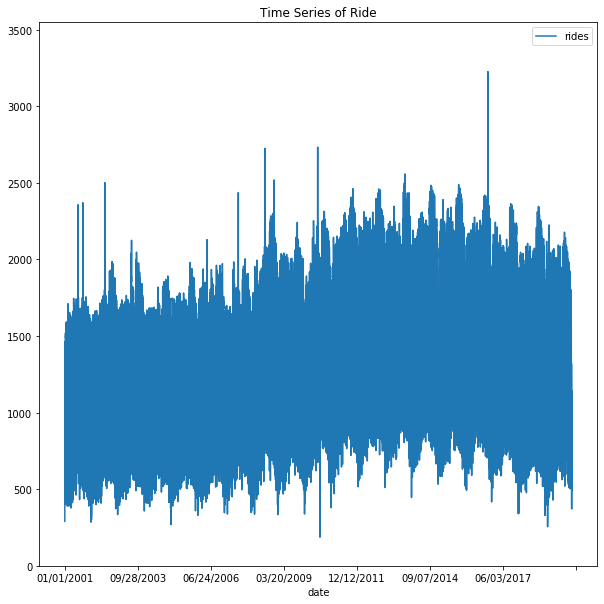

In [13]:
model_data.plot(kind='line', x='date', y='rides', 
                title='Time Series of Ride', figsize=(10,10), ylim=(0,(model_data.rides.max())*1.1))

In [14]:
## Column Renaming to fit Prophet Model
model_data.rename(columns = {'date' : 'ds' , 'rides' : 'y'}, inplace = True)
## Using Facebook's Prophet Library for Univariate Time Series Analysis

## Inherently Prophet uses a Linear Model. For Growth Trends (Population of a metro-politan like 
## Chicago will grow in the future, hence ridership is bound to increase). I will use a logistic growth
## trend model. I use a configurable cap with a assumed max limit of max_ridership*1.1 
## (1.1 is a assumed constant that can also be an increasing sequence)

In [21]:
def model_building(model_data,saturating_maximum):

    model = Prophet(changepoint_range       = CHANGEPOINT_RANGE,
                    #growth                  = GROWTH ,
                    interval_width          = INTERVAL_WIDTH, 
                    yearly_seasonality      = YEARLY_SEASONALITY,
                    weekly_seasonality      = WEEKLY_SEASONALITY,
                    changepoint_prior_scale = CHANGEPOINT_PRIOR_SCALE) 
    
    fitted_model = model.fit(model_data)
    
    future = fitted_model.make_future_dataframe(periods=365)
    
    #future['cap']   = saturating_maximum   ## Saturating Maximum
    
    forecast = fitted_model.predict(future)
    
    Forecast_Plot = fitted_model.plot(forecast)
    
    Plot_Components = fitted_model.plot_components(forecast)
    
    Interactive_Plot = plot_plotly(fitted_model,forecast)
    py.iplot(Interactive_Plot)
    
    return(forecast)
    ## Change Points can be added to Forecast
    #change_point_plot = add_changepoints_to_plot(fig.gca(), fitted_model, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2001-01-01  1231.814098   608.724946  1416.616637  1231.814098   
1    2001-01-02  1231.919697   784.520750  1567.353998  1231.919697   
2    2001-01-03  1232.025295   789.602861  1616.534681  1232.025295   
3    2001-01-04  1232.130894   773.817411  1588.469491  1232.130894   
4    2001-01-05  1232.236493   737.750201  1582.516359  1232.236493   
...         ...          ...          ...          ...          ...   
7302 2020-12-26  1588.942286   113.146412   945.920099  1584.417079   
7303 2020-12-27  1588.895240  -160.372493   658.877899  1584.357341   
7304 2020-12-28  1588.848193   938.336662  1795.924725  1584.297604   
7305 2020-12-29  1588.801147  1079.302797  1921.705416  1584.237867   
7306 2020-12-30  1588.754100  1097.679440  1935.877627  1584.178130   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     1231.814098     -229.271212           -229.271212           -229.271212   
1     1231.919697      -61.618102            -61.618102            -61.618102   
2     1232.025295      -47.984730            -47.984730            -47.984730   
3     1232.130894      -56.295077            -56.295077            -56.295077   
4     1232.236493      -85.058543            -85.058543            -85.058543   
...           ...             ...                   ...                   ...   
7302  1593.185149    -1073.788573          -1073.788573          -1073.788573   
7303  1593.152329    -1327.873349          -1327.873349          -1327.873349   
7304  1593.119509     -237.159344           -237.159344           -237.159344   
7305  1593.086690      -85.181940            -85.181940            -85.181940   
7306  1593.053870      -86.759342            -86.759342            -86.759342   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0     205.601866    205.601866    205.601866 -434.873078   -434.873078   
1     361.583419    361.583419    361.583419 -423.201521   -423.201521   
2     360.013333    360.013333    360.013333 -407.998063   -407.998063   
3     333.266413    333.266413    333.266413 -389.561490   -389.561490   
4     283.193269    283.193269    283.193269 -368.251811   -368.251811   
...          ...           ...           ...         ...           ...   
7302 -650.625789   -650.625789   -650.625789 -423.162784   -423.162784   
7303 -893.032511   -893.032511   -893.032511 -434.840838   -434.840838   
7304  205.601866    205.601866    205.601866 -442.761211   -442.761211   
7305  361.583419    361.583419    361.583419 -446.765359   -446.765359   
7306  360.013333    360.013333    360.013333 -446.772675   -446.772675   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      -434.873078                   0.0                         0.0   
1      -423.201521                   0.0                         0.0   
2      -407.998063                   0.0                         0.0   
3      -389.561490                   0.0                         0.0   
4      -368.251811                   0.0                         0.0   
...            ...                   ...                         ...   
7302   -423.162784                   0.0                         0.0   
7303   -434.840838                   0.0                         0.0   
7304   -442.761211                   0.0                         0.0   
7305   -446.765359                   0.0                         0.0   
7306   -446.772675                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
0                            0.0  1002.542886  
1                            0.0  1170.301595  
2                            0.0  1184.040566  
3                            0.0  1175.835817  
4                            0.0  1147.177951  
...                          ...          ...  
7302                         0.0   515.153713  
7303                         0.0   261.021891  
7

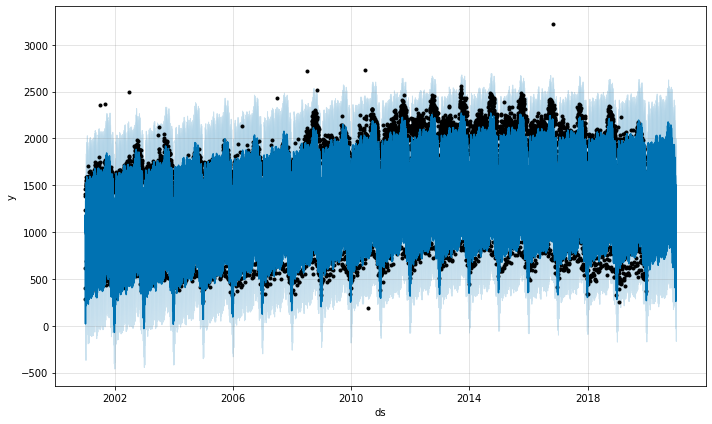

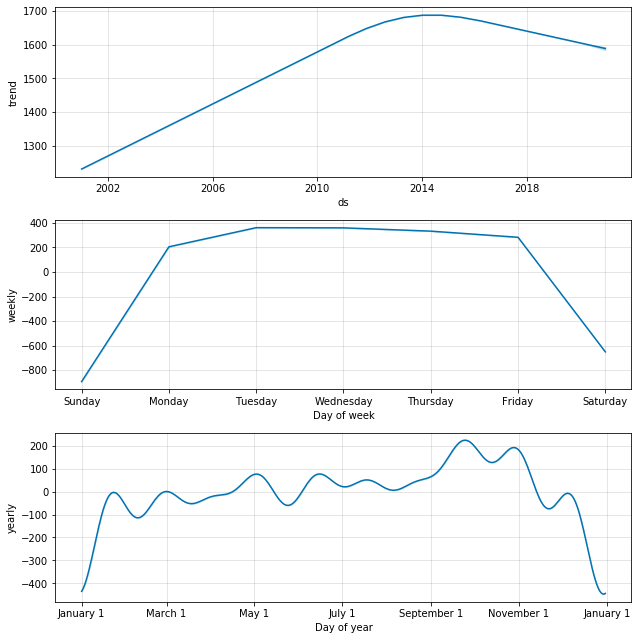

In [22]:
Model_Forecast = model_building(model_data, model_data.y.max()*1.1)
Model_Forecast
#daily_seasonality=True